In [30]:
import pandas as pd 
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

First, we read in the .csv files as pandas DataFrames. And we plot the locations of the stations.

In [20]:
df = pd.read_csv("../data/PRECIP_QUANTITY_SETHY_PRECIP_all_stat_1950101-20240101.csv")
df_meta = pd.read_csv("../data/sethy_station_meta.csv")

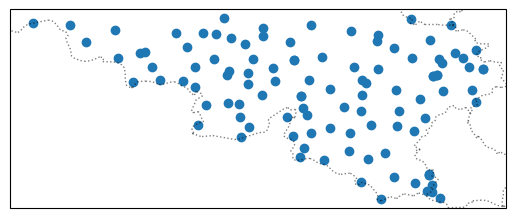

In [23]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines(alpha=0.7)
ax.add_feature(cfeature.BORDERS, alpha=0.5, linestyle="dotted")
ax.scatter(df_meta.lon, df_meta.lat)

Next, we process the DataFrames and convert them to xarray DataSets. 

In [122]:
ds_meta = xr.Dataset.from_dataframe(df_meta)

ds_raw = xr.Dataset.from_dataframe(df)
ds = ds_raw.swap_dims(index="time")
ds["time"] = np.array(ds.time, dtype='datetime64[ns]')
ds = ds.set_coords(['year', 'month', 'day', 'hour'])

locations = list(ds.data_vars)
da_combined = xr.concat([ds[loc] for loc in locations], dim="location")
da_combined = da_combined.assign_coords(location=locations)

ds = xr.Dataset({"pr" : da_combined})
ds

<xarray.Dataset>
Dimensions:   (time: 173126, location: 108)
Coordinates:
    index     (time) int64 0 1 2 3 4 5 ... 173121 173122 173123 173124 173125
    year      (time) int64 2004 2004 2004 2004 2004 ... 2023 2023 2023 2023 2023
    month     (time) int64 4 4 4 4 4 4 4 4 4 4 ... 12 12 12 12 12 12 12 12 12 12
    day       (time) int64 1 1 1 1 1 1 1 1 1 1 ... 31 31 31 31 31 31 31 31 31 31
    hour      (time) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
  * time      (time) datetime64[ns] 2004-04-01 ... 2023-12-31T23:00:00
  * location  (location) <U19 'Wavre' 'Louvain-La-Neuve' ... 'Bastogne'
Data variables:
    pr        (location, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.4 0.0 0.6

Now, we take a look at the period of the Vesder case. We find the locations with the five highest accumulated precipitation sums. We save this dataset for the students.

In [131]:
ds_period = ds.sel(time=slice("2021-07-12T01", "2021-07-17T00"))
pr_sum = ds_period.pr.sum("time")
pr_sum.location.sortby(pr_sum)

<xarray.DataArray 'location' (location: 108)>
array(['Wauthier-Braine', 'Marchienne-ecluse', 'Flamierge', 'Balmoral',
       'Somme-Leuze', 'Bierset', 'Feschaux', 'Chooz', 'Arlon-FUL', 'Oberkorn',
       'Kain', 'Mouscron', 'Comines-ecluse', 'Dergneau', 'Chievres.x',
       'Chievres.y', 'Roisin', 'Enghien', 'Peruwelz', 'Wasmuel',
       'Lillois-sur-le-Hain', 'Seneffe', 'Trivieres', 'Blaregnies', 'Soignies',
       'Solre S/S ecluse', 'Bousval', 'Orval', 'Uccle', 'Sivry', 'Momignies',
       'Perwez', 'Awans', 'Tubize', 'Monceau-ecluse', 'Straimont', 'Lanaye',
       'Helecine', 'Rouveroy', 'Vedrin.x', 'Vedrin.y', 'Mornimont-ecluse',
       'Sugny', 'Wavre', 'Robertville', 'Ciney', 'Waremme', 'Vresse',
       'Bouillon/Dohan', 'Marche', 'Boussu-en-Fagne', 'Cul-des-Sarts',
       'Ouffet', 'Fratin', 'Chatelet', 'Mean', 'Sankt-Vith', 'Florennes',
       'Saint-Gerard', 'Arlon-Aive.x', 'Arlon-Aive.y', 'Bertrix', 'Ligny',
       'Senzeille', 'Beauraing', 'Aubange', 'Gerpinnes', 'Gedinne',
       'Rochefort', 'Namoussart', 'Coo-inf..x', 'Coo-inf..y', 'Meix-le-Tige',
       'Torgny', 'Butgenbach.x', 'Butgenbach.y', 'Daverdisse', 'Athus',
       'Plate Taille', 'Landenne', 'Coo-sup..x', 'Coo-sup..y',
       'Louvain-La-Neuve', 'Petigny-barrage', 'Tailles', 'Bastogne',
       'Rachamps-Noville', 'Selange', 'Croix-Scaille', 'Gemmenich',
       'Steffeshausen', 'Crupet', 'Anseremme-ecluse.x', 'Anseremme-ecluse.y',
       'Sart-Tilman', 'Vielsalm', 'Saint-Hubert', 'Modave', 'Ortho',
       'Louveigne', 'Libin', 'Nassogne', 'Battice', 'Erezee', 'Neu-Hattlich',
       'Mont-Rigi', 'Spa', 'Jalhay'], dtype='<U19')
Coordinates:
  * location  (location) <U19 'Wauthier-Braine' 'Marchienne-ecluse' ... 'Jalhay'

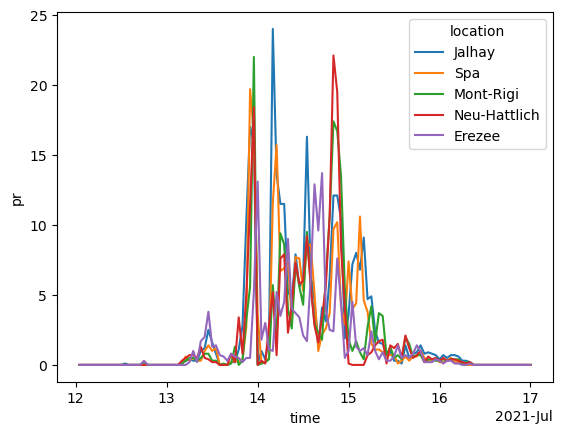

In [133]:
max_locations = ["Jalhay", "Spa", "Mont-Rigi", "Neu-Hattlich", "Erezee"]
ds_period.sel(location=max_locations).pr.plot(hue="location")

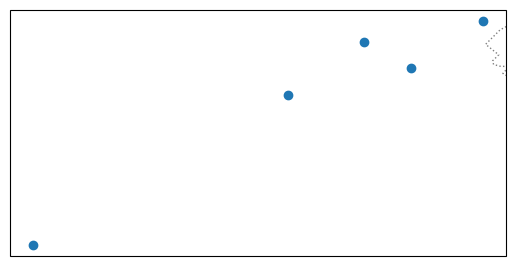

In [130]:
ds_meta_locs_list = list()

for location in max_locations:
    ds_meta_loc = ds_meta.where(ds_meta.name == location).dropna("index")
    ds_meta_locs_list.append(ds_meta_loc)

ds_meta_locs = xr.concat(ds_meta_locs_list, dim="index")

fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines(alpha=0.7)
ax.add_feature(cfeature.BORDERS, alpha=0.5, linestyle="dotted")
ax.scatter(ds_meta_locs.lon, ds_meta_locs.lat)
plt.show()

In [172]:
ds_sel = ds.sel(time=slice("2021-07-12T01", "2021-07-17T00")).sel(location=max_locations)
lons = list()
lats = list()

for location in ds_sel.location:
    ds_meta_loc = ds_meta.where(ds_meta.name == location).dropna("index")
    lons.append(ds_meta_loc.lon.values[0])
    lats.append(ds_meta_loc.lat.values[0])

ds_sel = ds_sel.assign_coords(lon=("location", lons), lat=("location", lats))
ds_sel.attrs = {"standard_name":"precipitation_flux", "long_name":"Precipitation", "units":"mm/h", "cell_methods":"time: mean"}
ds_sel.to_netcdf("../data/SETHY_pr_2021-07-12T01_2021-07-17T00.nc", engine="netcdf4")